# MFA: soil microbiome and properties


In [1]:
import pandas as pd
import numpy as np
import os
import biom
import re

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import prince

%matplotlib inline

In [2]:
#!mkdir /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries

In [3]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/MFA/berries


In [4]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [5]:
group_colors = {
    'Bacteria': "#440154FF",        # Dark purple  
    'Climate': "#39558CFF",         # Blue  
    'Fungi': "#238A8DFF",           # Teal  
    'Soil': "#56C667FF",            # Green  
    'Plots': "#DCE318FF",           # Yellow  
    }

# Load data

#### Microbiome

> ITS berries: try all berries (`berries_cOTUs_rarefied_labled.tsv`) as well as only harvest ones (`berries_harvest_cOTUs_rarefied_labled.tsv`)

In [6]:
df_ITS = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/berries-closedRefOTU/berries_harvest_cOTUs_rarefied_labled.tsv', sep='\t', index_col=0)
df_ITS.index.name = "SAMPLE_NAME"

In [7]:
df_ITS.shape

(317, 981)

#### Metadata

In [78]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_BerryChemistry.tsv', sep='\t')
chemistry_df = md_df[['SAMPLE_NAME',  'Tartrate_gL', 'Malate_gL','Glucose_gL', 'Fructose_gL']].set_index('SAMPLE_NAME')

chemistry_df

,Tartrate_gL,Malate_gL,Glucose_gL,Fructose_gL
SAMPLE_NAME,,,,
Lavaux_2021-08-31_must_Plot4,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot5,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot9,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot11,NaN,NaN,NaN,NaN
Lavaux_2021-08-31_must_Plot12,NaN,NaN,NaN,NaN
...,...,...,...,...
Lavaux_2023-09-20_must_Plot17_RepB,1.4960,0.0970,16.3860,18.247
Lavaux_2023-09-20_must_Plot17_RepC,1.2910,0.1040,18.6630,20.781
Lavaux_2023-09-20_must_Plot17_RepD,1.1200,0.0850,17.1530,18.839


In [79]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
md_df = md_df[md_df['sample_type']=='must']

# Plot metadata
plot_df = md_df[['SAMPLE_NAME', 'Altitude', 'Average_slope', 'Exposition','Average_radiation']].set_index('SAMPLE_NAME')
categorical_cols = ['Exposition']
plot_df_dummies = pd.get_dummies(plot_df, columns=categorical_cols, drop_first=True)
# Convert boolean columns to integers (0 or 1)
boolean_columns = plot_df_dummies.select_dtypes(include='bool').columns
plot_df_dummies[boolean_columns] = plot_df_dummies[boolean_columns].astype(int)

plot_df_dummies.tail()

,Altitude,Average_slope,Average_radiation,Exposition_South-West
SAMPLE_NAME,,,,
Lavaux_2023-09-20_must_Plot17_RepB,390,20,912.5,1
Lavaux_2023-09-20_must_Plot17_RepC,390,20,912.5,1
Lavaux_2023-09-20_must_Plot17_RepD,390,20,912.5,1
Lavaux_2023-09-20_must_Plot17_RepE,390,20,912.5,1
Lavaux_2021-09-30_must_Plot5_Row6/Vine30_ID37,400,30,912.5,1


In [80]:
md_df = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Climate.tsv', sep='\t')
md_df_soil = md_df[md_df['sample_type']=='must']

# Climate metadata
climate_df = md_df_soil[['SAMPLE_NAME', 'median_temperature', 'cv_temperature', 'median_rh', 'cv_rh' ]].set_index('SAMPLE_NAME')
#climate_df = md_df_soil[['SAMPLE_NAME', 'median_temperature',  'median_rh']].set_index('SAMPLE_NAME')


climate_df.head()

,median_temperature,cv_temperature,median_rh,cv_rh
SAMPLE_NAME,,,,
Lavaux_2021-08-31_must_Plot4,18.650958,22.587667,72.792393,16.567322
Lavaux_2021-08-31_must_Plot5,19.047366,22.104867,70.192394,16.331714
Lavaux_2021-08-31_must_Plot9,18.256629,22.831881,73.077585,16.570451
Lavaux_2021-08-31_must_Plot11,18.541438,23.246939,72.501870,16.118351
Lavaux_2021-08-31_must_Plot12,18.244984,23.615955,72.934711,16.661423


In [81]:
# make a metadata df
df_metadata = md_df_soil[['SAMPLE_NAME', 'Year', 'Plot', 'COLLECTION_DATE']].set_index('SAMPLE_NAME')

### Merge

In [82]:
# Merge all dataframes on their index
df_mfa = (
    climate_df
    .join(plot_df_dummies, how="inner")
    .join(chemistry_df, how="inner")
    .join(df_ITS, how="inner")
)

# Drop rows with any NA values
df_mfa.dropna(inplace=True)

# Print the shape to check the final size
print(df_mfa.shape)


(302, 993)


In [83]:
# Keep track of the columns' origins
Fun_columns = df_ITS.columns.tolist()
plots_columns = plot_df_dummies.columns.tolist()
climate_columns = climate_df.columns.tolist()
chemistry_columns = chemistry_df.columns.tolist()

multi_index_columns = (
    [('Climate', col) for col in climate_columns] +
    [('Plots', col) for col in plots_columns] +
    [('Chemistry', col) for col in chemistry_columns] + 
    [('Fungi', col) for col in Fun_columns])

# Subset data and assign multi-index
df_mfa.columns = pd.MultiIndex.from_tuples(multi_index_columns)  # Assign multi-index
df_mfa = df_mfa.astype("float64")

# Extract the group names (first level of multi-index)
groups = df_mfa.columns.levels[0].tolist()

df_mfa.shape

(302, 993)

In [84]:
# drop columns with zero variance 
zero_var_cols = df_mfa.std() == 0
df_mfa = df_mfa.loc[:, ~zero_var_cols]

df_mfa.shape

(302, 961)

In [85]:
# Check if there are any NaN values in df_mfa
nan_cells = df_mfa.isna().sum().sum()
print(f"Total NaN cells in df_mfa: {nan_cells}")

Total NaN cells in df_mfa: 0


# MFA 

## How many Components?

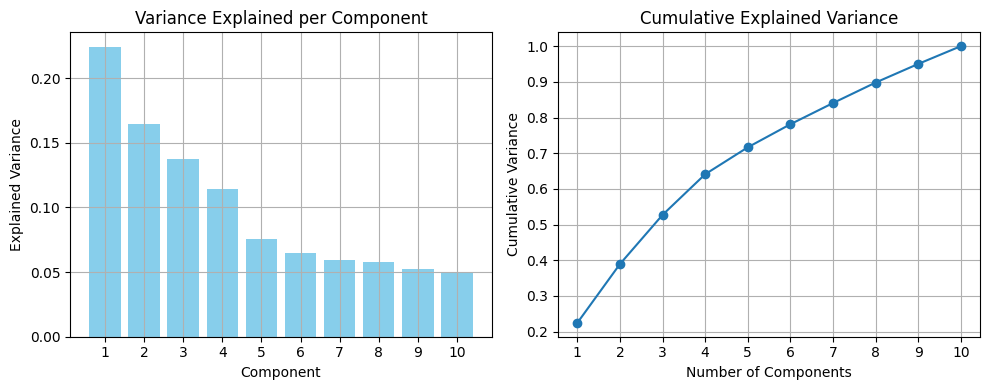

In [86]:
# Define the number of components to test
n_components = 10

# Define MFA and fit the model
mfa = prince.MFA(
    n_components=n_components,  
    n_iter=3, 
    copy=True,
    check_input=True,
    random_state=42)

# Fit MFA to the data (excluding metadata columns)
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

# Get explained variance per component
explained_variance_ratio = mfa.eigenvalues_ / np.sum(mfa.eigenvalues_)

# Create subplots for explained variance and cumulative variance plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar plot for variance explained per component
axes[0].bar(range(1, n_components + 1), explained_variance_ratio[:n_components], color='skyblue')
axes[0].set_title('Variance Explained per Component')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_xticks(range(1, n_components + 1))
axes[0].grid(True)

# Line plot for cumulative explained variance (elbow plot)
axes[1].plot(range(1, n_components + 1), np.cumsum(explained_variance_ratio[:n_components]), marker='o', linestyle='-')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].grid(True)

# Adjust layout to ensure proper display
plt.tight_layout()
plt.show()

In [87]:
# Initialize MFA model
mfa = prince.MFA(
    n_components=6,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

# Fit MFA with multi-index groups
mfa = mfa.fit(
    df_mfa,
    groups=groups,
    supplementary_groups=None)

mfa_results = mfa.transform(df_mfa)
# Merge MFA results with metadata to retain 'year' information
mfa_results = mfa_results.merge(df_metadata, left_index=True, right_index=True)

mfa.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.869,4.64%,4.64%
1,1.374,3.41%,8.05%
2,1.149,2.85%,10.90%
3,0.950,2.36%,13.26%
4,0.633,1.57%,14.83%
5,0.546,1.36%,16.19%


/scratch/lfloerl/tmpdata/ipykernel_2821575/1232054175.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_plot, palette='viridis')


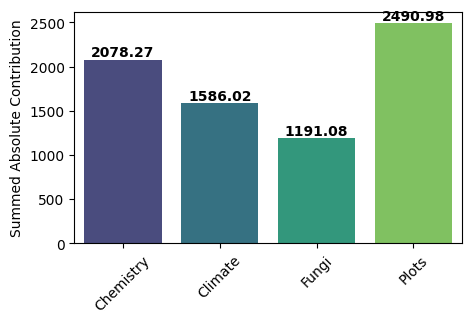

In [88]:
partial_coords = mfa.partial_row_coordinates(df_mfa)

# Assuming `partial_coords` is the dataframe you obtained from MFA
df_abs_sum = partial_coords.abs().sum()

# Convert to DataFrame for plotting
df_plot = df_abs_sum.groupby(level=0).sum().reset_index()
df_plot.columns = ['Group', 'Sum of Contributions']

# Plot
plt.figure(figsize=(5, 3))
ax = sns.barplot(x='Group', y='Sum of Contributions', data=df_plot, palette='viridis')
# Add numeric values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Summed Absolute Contribution')
plt.show()

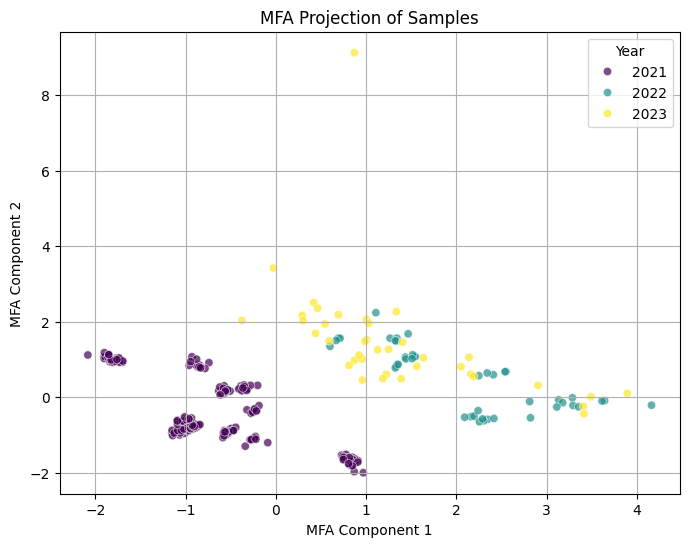

In [89]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="Year", palette="viridis", alpha=0.7)
plt.xlabel("MFA Component 1")
plt.ylabel("MFA Component 2")
plt.title("MFA Projection of Samples")
plt.grid()
plt.show()

In [90]:
# Extract coordinates of individuals (first 2 components)
individuals = mfa_results.iloc[:, :2].values  

# Extract variable loadings (first 2 components) and drop multi-index properly
variable_loadings_df = mfa.column_correlations.iloc[:, :2].copy().reset_index()

# Ensure correct column names
variable_loadings_df.columns = ["Variable", "MFA Comp 1", "MFA Comp 2"]

# Compute Loadings Contribution (sum of absolute correlations)
variable_loadings_df["Loadings Contribution"] = variable_loadings_df[["MFA Comp 1", "MFA Comp 2"]].abs().sum(axis=1)

# Handle infinite values: replace with max Loadings Contribution + 0.1
max_load = variable_loadings_df.loc[np.isfinite(variable_loadings_df["Loadings Contribution"]), "Loadings Contribution"].max()
variable_loadings_df["Loadings Contribution"] = variable_loadings_df["Loadings Contribution"].replace([np.inf, -np.inf], max_load + 0.1)

# Sort by Loadings Contribution
variable_loadings_df = variable_loadings_df.sort_values(by="Loadings Contribution", ascending=False)

# Extract first character of "Variable" as "group"
variable_loadings_df["group"] = variable_loadings_df["Variable"].apply(lambda x: x[0])

# Select top 10 based on Loadings Contribution
top_loadings = variable_loadings_df.nlargest(10, "Loadings Contribution").copy()

# Extract variable names from tuples more robustly
top_loadings["Variable"] = top_loadings["Variable"].astype(str).str.extract(r",\s*([^,)]*)\)?$")[0]


# Function to extract the family name
def extract_family(variable):
    match = re.search(r"f__([^;]+)", variable)
    return match.group(1) if match else variable  # Return the family name if found, else keep the original value

# Apply function only to rows where 'Variable' starts with 'Bacteria_' or 'Fungi_'
mask = top_loadings['Variable'].str.startswith(("'d__Bacteria", "'k__Fungi"))
top_loadings.loc[mask, 'Variable'] = top_loadings.loc[mask, 'Variable'].apply(extract_family)


top_loadings

,Variable,MFA Comp 1,MFA Comp 2,Loadings Contribution,group
2,'Glucose_gL',-0.672540,0.609226,1.281766,Chemistry
3,'Fructose_gL',-0.663909,0.610033,1.273942,Chemistry
6,'median_rh',-0.801890,-0.437746,1.239636,Climate
1,'Malate_gL',-0.715034,-0.459184,1.174218,Chemistry
4,'median_temperature',0.445056,0.655174,1.100230,Climate
5,'cv_temperature',0.784866,0.305504,1.090370,Climate
957,'Altitude',0.490921,-0.561099,1.052020,Plots
7,'cv_rh',0.790645,0.143064,0.933708,Climate
958,'Average_slope',0.508686,-0.138640,0.647326,Plots
447,unidentified,0.348567,0.281848,0.630415,Fungi


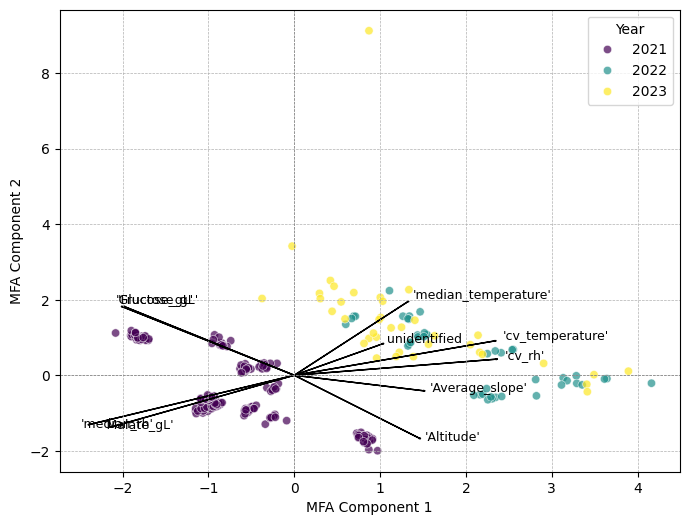

In [91]:
# Biplot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], hue="Year", palette="viridis", alpha=0.7)


# Define a scaling factor to extend the arrows
scaling_factor = 3 # Adjust this value to control arrow length
# Plot the top loadings as arrows
for i, row in top_loadings.iterrows():
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color="black", length_includes_head=True)
    
    ax.text(row["MFA Comp 1"] * (scaling_factor + 0.1),  # Adjust text position accordingly
            row["MFA Comp 2"] * (scaling_factor + 0.1), 
            row["Variable"], fontsize=9)


# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
#ax.set_title("MFA Biplot (Samples Colored by Year)")
ax.grid(True, linestyle="--", linewidth=0.5)
ax.legend(title="Year", bbox_to_anchor=(1, 1))

plt.show()

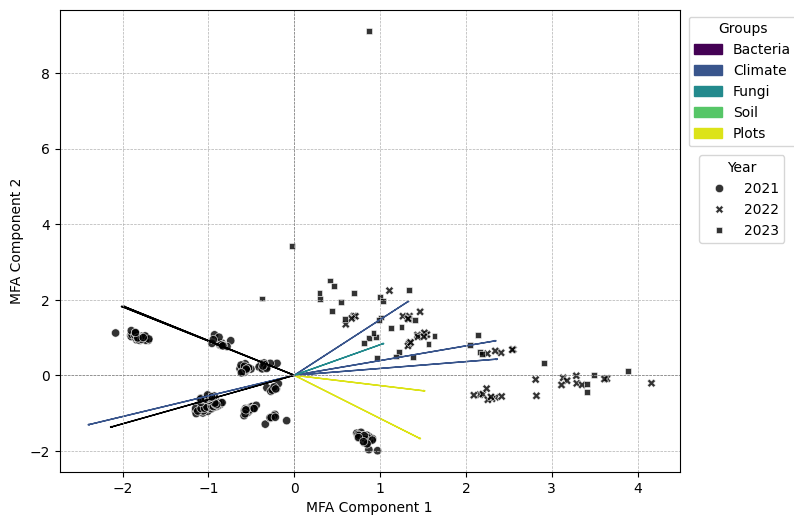

In [92]:
# Biplot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot of individuals, colored by year
sns.scatterplot(data=mfa_results, x=mfa_results.iloc[:, 0], y=mfa_results.iloc[:, 1], style="Year", alpha=0.8, color='black')

# Define a scaling factor to extend the arrows
scaling_factor = 3  

# Create a color map based on the group and intensity (Total Contribution)
norm = plt.Normalize(vmin=top_loadings['Loadings Contribution'].min(), vmax=top_loadings['Loadings Contribution'].max())  
sm = plt.cm.ScalarMappable(cmap='Greys', norm=norm)
sm.set_array([])

# Plot the top loadings as arrows with colors based on the group and intensity by Total Contribution
for i, row in top_loadings.iterrows():
    group_color = group_colors.get(row['group'], 'black')  
    ax.arrow(0, 0, row["MFA Comp 1"] * scaling_factor, row["MFA Comp 2"] * scaling_factor, 
             head_width=0.02, head_length=0.02, color=group_color, length_includes_head=True)

# Add first legend for groups (custom patches)
group_legend_patches = [matplotlib.patches.Patch(color=color, label=group) for group, color in group_colors.items()]
group_legend = ax.legend(handles=group_legend_patches, title="Groups", loc="upper right", bbox_to_anchor=(1.2, 1))

# Add second legend for Year (from scatterplot)
year_legend = ax.legend(title="Year", bbox_to_anchor=(1.18, 0.7))

# Add both legends back to the plot
ax.add_artist(group_legend)

# Formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_xlabel("MFA Component 1")
ax.set_ylabel("MFA Component 2")
ax.set_title("")

# Show grid
ax.grid(True, linestyle="--", linewidth=0.5)

plt.show()
